In [ ]:
# Pump-probe simple analysis example

This is a simple analysis example on how to:
* load data and corrections for the Alvra 4.5M Jungfrau
* correct Jungfrau images
* do some basic analysis and plotting

First, you import modules for `Numpy` (matrix manipulation), `H5Py` (HDF5 files), `matplotlib` (plotting) and `jungfrau_utils` (Jungfrau corrections)

In [14]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import h5py
import matplotlib.pyplot as plt

Then, you have a look at the data directory (the `!` executes a shell command)

In [207]:
DIR = "/gpfs/sf-data/alvra/raw/p16581/"

!ls -lah -t $DIR

total 16T
-rw-r--r--. 1            16581 p16581  53G Dec 18 07:12 CuPCP_0126_lxt-6.5800.h5
drwxrws---. 3 root             p16581  32K Dec 18 07:02 .
-rw-r--r--. 1            16581 p16581  53G Dec 18 07:01 CuPCP_0125_lxt-6.5800.h5
-rw-r--r--. 1            16581 p16581  53G Dec 18 06:47 CuPCP_0124_lxt-5.58027.h5
-rw-r--r--. 1            16581 p16581  53G Dec 18 06:36 CuPCP_0123_lxt-5.58027.h5
-rw-r--r--. 1            16581 p16581  53G Dec 18 06:25 CuPCP_0122_lxt-5.58027.h5
-rw-r--r--. 1            16581 p16581  53G Dec 18 06:14 CuPCP_0121_lxt-5.58027.h5
-rw-r--r--. 1            16581 p16581  53G Dec 18 06:03 CuPCP_0120_lxt-5.58027.h5
-rw-r--r--. 1            16581 p16581  53G Dec 18 05:52 CuPCP_0119_lxt-5.58027.h5
-rw-r--r--. 1            16581 p16581  53G Dec 18 05:30 CuPCP_0118_lxt-6.180.h5
-rw-r--r--. 1            16581 p16581  53G Dec 18 05:18 CuPCP_0117_lxt-6.180.h5
-rw-r--r--. 1            16581 p16581  53G Dec 18 05:07 CuPCP_0116_lxt-6.180.h5
-rw-r--r--. 1            16581 p16581 

Then, get the data files for pedestal and gain corrections, and load the data:

In [16]:
#pede_file = "/sf/alvra/data/res/p16581/pedestal_20171214_1437_res.h5"
pede_file = "/sf/alvra/data/res/p16581/pedestal_20171216_1645_res.h5"
gain_file = "/sf/alvra/config/jungfrau/jungfrau_4p5_gaincorrections_v0.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    mask = file["pixel_mask"][:]
    
print("Dimensions of G: ", G.shape)

Dimensions of G:  (4, 512, 9216)


`G` and `P` are three dimensional arrays, where the 0-th dimension is the gain level: `G0, G1, G2, HG0`. In this case, we ran the JF in high gain mode (`HG0`)

Do a simple plot:

Ok, time to load a real data file. Let's have a look at its content, and load data and pulse ids:

In [17]:
fileName = "/CuPCP_0001.h5"
jf_file = h5py.File(DIR + fileName)
print(list(jf_file["jungfrau"].keys()))

images = jf_file["jungfrau/data"]
pulse_ids = jf_file["jungfrau/pulse_id"]

['daq_rec', 'daq_recs', 'data', 'frame', 'framenum_diff', 'framenums', 'is_good_frame', 'missing_packets_1', 'missing_packets_2', 'pulse_id', 'pulse_id_diff', 'pulse_ids']


The images need to be correct. There is the `ju.apply_gain_pede` routine just for this (type `ju.apply_gain_pede?` for the help):

In [ ]:
nframes = 1000
#nframes=images.shape(0)

total = 0
threshold = 1
#roi = [[150, 190], [5780, 5880]]
roi = [[0, -1], [0, -1]]

for i in range(nframes):
    image = images[i][:]
    total += ju.apply_gain_pede(image, G=G, P=P, pixel_mask=mask, highgain=True)[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]

total /= nframes

plt.figure()
plt.imshow(total, origin="lower", vmin=0, vmax=0.4)
plt.colorbar()
plt.show()

In [18]:
def rebin_sum(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).sum(axis=1)

def rebin_mean(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).mean(axis=1)

In [19]:
# Convert energy to a number of photons counting values falling within a particular range.
# This will always return integer photon counts.
def convert_to_photon_num_range(image):
    return np.ceil(np.divide(image - photon_range[0], np.mean(photon_range)))

# Convert energy to a number of photons using the central energy of a single photon.
# This can return fractional number of photons.`
def convert_to_photon_num_mean(image):
    return image / np.mean(photon_range)

In [ ]:
print(images.shape[0])

In this example, beam runs at 10 Hz, and laser at 5Hz. So, if the pulse id is a multiple of 20 laser is on, otherwise not. We can create a boolean array with this info:

In [22]:
pulse_ids[0:10] % 20 == 0  # False = laser off


array([False,  True, False,  True, False,  True, False,  True, False,  True], dtype=bool)

In [23]:
laser_on_off = pulse_ids[:] % 20 == 0 
######## default is == 0 #############!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


Time to loop on images. Signal is well localized, so we can set up a ROI. Then we loop over images and fill two variables containing the laser on / off spectra.

In [222]:
###### %%time
files = ["CuPCP_0128_lxt-6.900.h5","CuPCP_0129_lxt-6.900.h5"]

# Ka emission on InSb(111)
roi1 = [[180, 190], [5750, 5910]]

#Ka emission on Si(111)
roi2 = [[150, 190], [9050, 9210]]

spectra_on_roi1 = 0
spectra_off_roi1 = 0
spectra_on_roi2 = 0
spectra_off_roi2 = 0

n_spectra_on = 0
n_spectra_off = 0

threshold = 1
photon_range = (1, 3)

P_r_roi1 = P[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
G_r_roi1 = G[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
mask_r_roi1 = mask[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]

P_r_roi2 = P[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
G_r_roi2 = G[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
mask_r_roi2 = mask[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]

for f in files:
    jf_file = h5py.File(DIR + f, "r")
    print("Processing %s" % (DIR + f))
#     images = jf_file["jungfrau/data"]
    pulse_ids = jf_file["jungfrau/pulse_id"]
    laser_on_off = pulse_ids[:] % 20 == 0
    #nframes = 1000
    nframes = pulse_ids.size
    
    for i in range(nframes):
        image = jf_file["jungfrau/data"][i,:,:]
        image_roi1 = image[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi1 = ju.apply_gain_pede(image_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=True)
        image_roi1[image_roi1 < threshold] = 0
        image_roi1 = convert_to_photon_num_range(image_roi1)
        
        image_roi2 = image[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        image_roi2 = ju.apply_gain_pede(image_roi2, G=G_r_roi2, P=P_r_roi2, pixel_mask=mask_r_roi2, highgain=True)
        image_roi2[image_roi2 < threshold] = 0
        image_roi2 = convert_to_photon_num_range(image_roi2)
        
        if laser_on_off[i]:
            spectra_on_roi1 += image_roi1.sum(axis=0)
            spectra_on_roi2 += image_roi2.sum(axis=0)
            n_spectra_on += 1

        else:
            spectra_off_roi1 += image_roi1.sum(axis=0)
            spectra_off_roi2 += image_roi2.sum(axis=0)
            n_spectra_off += 1

print(n_spectra_off)
print(n_spectra_on)

Processing /gpfs/sf-data/alvra/raw/p16581/CuPCP_0128_lxt-6.900.h5
Processing /gpfs/sf-data/alvra/raw/p16581/CuPCP_0129_lxt-6.900.h5
6000
6000


In [216]:
###### %%file to upload.....
files = ["CuPCP_0127_lxt-6.5800.h5"]


# Ka emission on InSb(111)
roi1 = [[180, 190], [5750, 5910]]

#Ka emission on Si(111)
roi2 = [[150, 190], [9050, 9210]]

for f in files:
    jf_file = h5py.File(DIR + f, "r")
    print("Processing %s" % (DIR + f))
#     images = jf_file["jungfrau/data"]
    pulse_ids = jf_file["jungfrau/pulse_id"]
    laser_on_off = pulse_ids[:] % 20 == 0
    #nframes = 1000
    nframes = pulse_ids.size
    
    for i in range(nframes):
        image = jf_file["jungfrau/data"][i,:,:]
        image_roi1 = image[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi1 = ju.apply_gain_pede(image_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=True)
        image_roi1[image_roi1 < threshold] = 0
        image_roi1 = convert_to_photon_num_range(image_roi1)
        
        image_roi2 = image[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        image_roi2 = ju.apply_gain_pede(image_roi2, G=G_r_roi2, P=P_r_roi2, pixel_mask=mask_r_roi2, highgain=True)
        image_roi2[image_roi2 < threshold] = 0
        image_roi2 = convert_to_photon_num_range(image_roi2)
        
        if laser_on_off[i]:
            spectra_on_roi1 += image_roi1.sum(axis=0)
            spectra_on_roi2 += image_roi2.sum(axis=0)
            n_spectra_on += 1

        else:
            spectra_off_roi1 += image_roi1.sum(axis=0)
            spectra_off_roi2 += image_roi2.sum(axis=0)
            n_spectra_off += 1

print(n_spectra_off)
print(n_spectra_on)

Processing /gpfs/sf-data/alvra/raw/p16581/CuPCP_0127_lxt-6.5800.h5
9000
9000


<IPython.core.display.Javascript object>


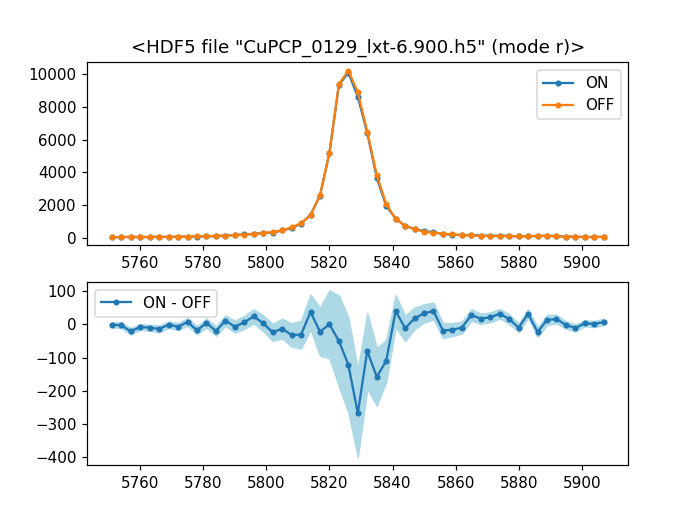

In [224]:
# # # Choose one!!!
spectra_on = spectra_on_roi1.copy()
spectra_off = spectra_off_roi1.copy()
x_axis = np.arange(roi1[1][0], roi1[1][1])

# spectra_on = spectra_on_roi2.copy()
# spectra_off = spectra_off_roi2.copy()
# x_axis = np.arange(roi2[1][0], roi2[1][1])
1
bin_ = 3
spectra_on_rebin = rebin_sum(spectra_on)
spectra_off_rebin = rebin_sum(spectra_off)
x_axis_rebin = rebin_mean(x_axis)

spectra_on_err=np.sqrt(spectra_on_rebin)
spectra_off_err=np.sqrt(spectra_off_rebin)
plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin,spectra_on_rebin, label="ON",marker='.')
plt.plot(x_axis_rebin,spectra_off_rebin, label="OFF",marker='.')
plt.legend(loc="best")
plt.title(jf_file)

low_err= (spectra_on_rebin - spectra_off_rebin)-np.sqrt(spectra_on_err**2+spectra_off_err**2)
high_err= (spectra_on_rebin - spectra_off_rebin)+np.sqrt(spectra_on_err**2+spectra_off_err**2)

plt.subplot(212)
plt.plot(x_axis_rebin,spectra_on_rebin - spectra_off_rebin, label="ON - OFF",marker='.')
plt.legend(loc="best")
plt.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
plt.show()
   

In [ ]:
#Ka emission on Si(111)
roi = [[150, 190], [9050, 9210]]
spectra_on1 = 0
spectra_off1 = 0
n_spectra_on1 = 0
n_spectra_off1 = 0
spectra_on_err1=0
spectra_off_err1=0


#nframes = 6000
#nframes = images.shape[0]
threshold = 1
photon_range = (1, 3)



P_r = P[:, roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]
G_r = G[:, roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]
mask_r = mask[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]

files = ["BAPO_800mbar_He_minus200ps_10uJ_T-2p5_36.h5","BAPO_800mbar_He_minus200ps_10uJ_T-2p5_37.h5",
         "BAPO_800mbar_He_minus200ps_10uJ_T-2p5_38.h5","BAPO_800mbar_He_minus200ps_10uJ_T-2p5_39.h5"]
for f in files:
    jf_file = h5py.File(DIR + f, "r")
    print("Loading %s" % (DIR + f))
    images = jf_file["jungfrau/data"]
    pulse_ids = jf_file["jungfrau/pulse_id"]
    laser_on_off = pulse_ids[:] % 20 == 0
    #nframes = 1000
    nframes = images.shape[0]
    for i in range(nframes):
        image = images[i, roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]
        image = ju.apply_gain_pede(image, G=G_r, P=P_r, pixel_mask=mask_r, highgain=True)
        image[image < threshold] = 0
        image = convert_to_photon_num_range(image)

        if laser_on_off[i]:
            spectra_on1 += image.sum(axis=0)
            n_spectra_on1 += 1

        else:
            spectra_off1 += image.sum(axis=0)
            n_spectra_off1 += 1


        

print(n_spectra_off1)
print(n_spectra_on1)


In [ ]:
bin_ = 4
roi = [[150, 190], [9050, 9210]]
x_axis1 = np.arange(roi[1][0], roi[1][1])

spectra_on_rebin1 = rebin_sum(spectra_on1)
spectra_off_rebin1 = rebin_sum(spectra_off1)
x_axis_rebin1 = rebin_mean(x_axis1)

spectra_on_err1=np.sqrt(spectra_on_rebin1)
spectra_off_err1=np.sqrt(spectra_off_rebin1)
plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin1,spectra_on_rebin1, label="ON")
plt.plot(x_axis_rebin1,spectra_off_rebin1, label="OFF")
plt.legend(loc="best")
plt.title(jf_file)

low_err1= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err1= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)

plt.subplot(212)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF")
plt.legend(loc="best")
plt.fill_between(x_axis_rebin1, low_err1, high_err1, color='lightblue')
plt.show()
   

In [ ]:
nframes = 1000
#nframes=images.shape[0]

# Ka emission on InSb(111)
roi = [[170, 190], [5650, 5880]]

#roi = [[0, -1], [0, -1]]

bins = np.arange(0, 20, 0.1)
histo = 0

for i in range(nframes):
    image = images[i][:]
    corr = ju.apply_gain_pede(image, G=G, P=P, pixel_mask=mask, highgain=True)[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]
    h, b = np.histogram(corr.ravel(), bins)
    histo += h
    

plt.figure()
plt.bar(bins[:-1], histo, width=bins[1] - bins[0], log=True)
plt.show()